In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
##Import any other packages you may need here
!pip install pydicom
from itertools import chain
from pydicom import dcmread
from skimage import io

Defaulting to user installation because normal site-packages is not writeable


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2997,00014750_000.png,No Finding,0,14750,051Y,M,PA,2992,2965,0.143,0.143
748,00003919_000.png,No Finding,0,3919,060Y,M,PA,2500,2048,0.171,0.171
4201,00020648_004.png,Atelectasis|Infiltration,4,20648,054Y,M,PA,3056,2544,0.139,0.139


In [3]:
#Loading sample data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


# Data Cleaning

In [4]:
df = all_xray_df.copy()
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [5]:
# replace spaces in column names with _
df.columns = df.columns.str.replace(' ', '_')
df.head(5)

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed:_11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [6]:
#Splitting the original image [width, height] and original image pixel spacing [x, y] column
OriginalImageWidth = df.iloc[: , 7]
OriginalImageHeight = df.iloc[: , 8]
OriginalImagePixelSpacing_x = df.iloc[: , 9]
OriginalImagePixelSpacing_y = df.iloc[: , 9]

In [7]:
# select only the first seven columns without the image data
df = df.iloc[:,0:7]

# and add the image data as new columns
df['OriginalImageWidth'] = list(OriginalImageWidth) 
df['OriginalImageHeight'] = list(OriginalImageHeight) 
df['OriginalImagePixelSpacing_x'] = list(OriginalImagePixelSpacing_x) 
df['OriginalImagePixelSpacing_y'] = list(OriginalImagePixelSpacing_y) 

df.head(1)

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143


# Gender Distribution

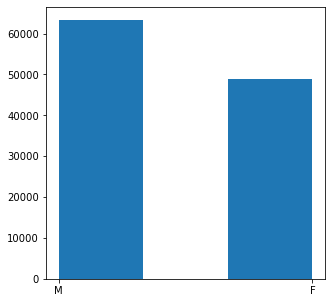

Male Patients: 63340
Female Patients: 48780
There are 1.3 male patients for every female patient.


In [8]:
plt.figure(figsize=(5,5))
plt.hist(df.Patient_Gender, bins = 3)
plt.show()

male_patiens = len(list(filter(None, df.Patient_Gender == "M")))
female_patiens = len(list(filter(None, df.Patient_Gender == "F")))
print("Male Patients:", male_patiens)
print("Female Patients:", female_patiens)
print("There are 1.3 male patients for every female patient.")

# Age Distribution

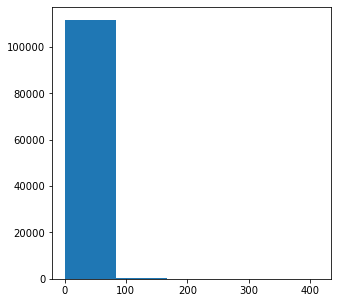

In [9]:
plt.figure(figsize=(5,5))
plt.hist(df.Patient_Age, bins = 5)
plt.show()

In [10]:
patiens_over_60 = len(list(filter(None, df.Patient_Age > 60)))
print('Their are ',patiens_over_60,'patients over 60')

Their are  24663 patients over 60


In [11]:
patiens_over_90 = len(list(filter(None, df.Patient_Age > 90)))
print('Their are ',patiens_over_90,'patients over 90')

Their are  51 patients over 90


In [12]:
is_not_over_90 =  df.Patient_Age < 91
df = df[is_not_over_90]

patiens_over_90 = len(list(filter(None, df.Patient_Age > 90)))
patiens_over_90

0

In [13]:
patiens_over_35 = len(list(filter(None, df.Patient_Age > 35)))
print('Their are ',patiens_over_35,'patients over 35')

Their are  82345 patients over 35


Min Age: 1
Max Age: 90
Mean Age: 46.85832835128358
Median Age: 49.0



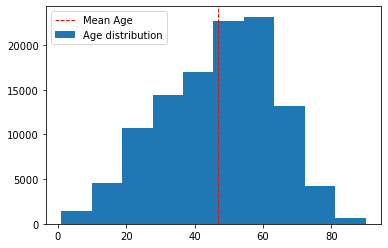

In [14]:
#Getting some insightful statistical values for age i.e. Minimum age, Maximum Age, Mean Age and Median Age

mean_age = np.mean(df.Patient_Age)
median_age = np.median(df.Patient_Age)
min_age = np.min(df.Patient_Age)
max_age = np.max(df.Patient_Age)

print("Min Age:", min_age)
print("Max Age:", max_age)
print("Mean Age:", mean_age)
print("Median Age:", median_age)
print("")

fig,ax = plt.subplots()

data_line = ax.hist(df.Patient_Age, label='Age distribution')
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=1, label='Mean Age')
legend = ax.legend(loc='upper left')

plt.show()

# X-ray Orientation

In [15]:
print(set(df.View_Position))

{'AP', 'PA'}


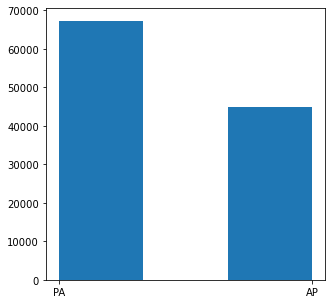

PA: 67277
AP: 44792


In [16]:
plt.figure(figsize=(5,5))
plt.hist(df.View_Position, bins = 3)
plt.show()

PA = len(list(filter(None, df.View_Position == "PA")))
AP = len(list(filter(None, df.View_Position == "AP")))
print("PA:", PA)
print("AP:", AP)


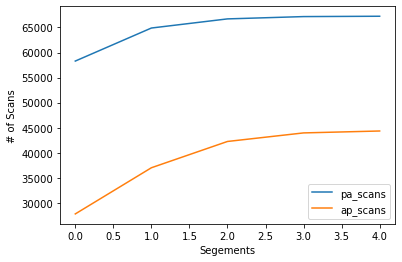

In [17]:
under_10_follow_ups = df["Follow-up_#"] < 11
under_25_follow_ups = df["Follow-up_#"] < 26
under_50_follow_ups = df["Follow-up_#"] < 51
under_80_follow_ups = df["Follow-up_#"] < 81
under_100_follow_ups = df["Follow-up_#"] < 101

pa_scans = []
ap_scans = []

for segment in [under_10_follow_ups, under_25_follow_ups, under_50_follow_ups, under_80_follow_ups, under_100_follow_ups]:
    tmp_df = df[segment]
    PA = len(list(filter(None, tmp_df.View_Position == "PA")))
    AP = len(list(filter(None, tmp_df.View_Position == "AP")))
    pa_scans.append(PA)
    ap_scans.append(AP)

plt.plot(pa_scans, label = "pa_scans")
plt.plot(ap_scans, label = "ap_scans")
plt.xlabel('Segements')
plt.ylabel('# of Scans')
plt.legend()
plt.show()


The number of AP-Scans does increase a little bit more than the number of PA-Scans the more follow ups a patient has. This can mean that sicker patients get more AP-Scans, wich would make sense.

# Case Distribution

In [18]:
all_labels = np.unique(list(chain(*df['Finding_Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

d = df.copy()

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        d[c_label] = d['Finding_Labels'].map(lambda finding: 1 if c_label in finding else 0)
d.head(1)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0


In [19]:
d[all_labels].sum()/len(d)

Atelectasis           0.103079
Cardiomegaly          0.024762
Consolidation         0.041635
Edema                 0.020541
Effusion              0.118793
Emphysema             0.022450
Fibrosis              0.015026
Hernia                0.002026
Infiltration          0.177453
Mass                  0.051549
No Finding            0.538347
Nodule                0.056456
Pleural_Thickening    0.030169
Pneumonia             0.012760
Pneumothorax          0.047301
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

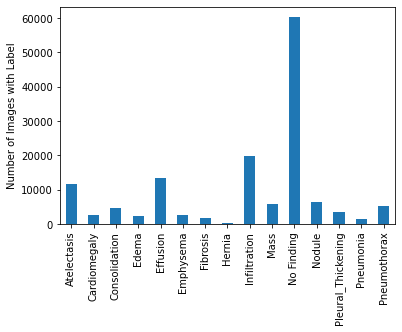

In [20]:
ax = d[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

In [21]:
pneumonia_cases = d[d.Pneumonia==1].shape[0]
print("There are ", pneumonia_cases, " records with Pneumonia listet in the Finding Labes column")

There are  1430  records with Pneumonia listet in the Finding Labes column


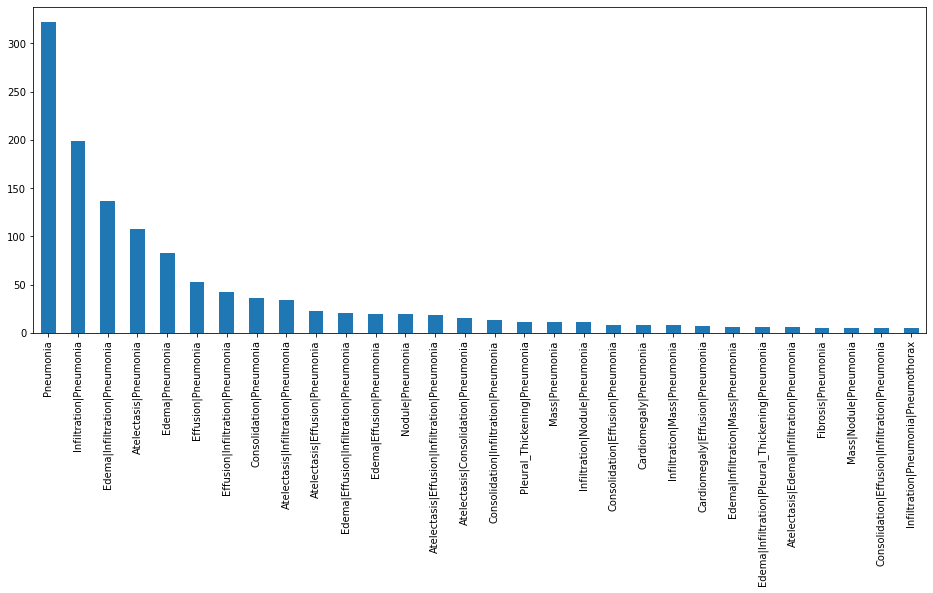

In [22]:
plt.figure(figsize=(16,6))
d[d.Pneumonia==1]['Finding_Labels'].value_counts()[0:30].plot(kind='bar')


It looks like that Pneumonia occurs most often alone. The most often co-occurrence is Infiltration. The third most often case is Pneumonia with Infiltration and Edema. The fourth most common co-occurrence ist with Atelectasis. The fourth most common case is Pneumonia with Edema.

Now let's look with a little bit more detail on the patients who do have Pneumonia

In [23]:
d_pneumonia = d[['Patient_ID', 'Finding_Labels', 'Follow-up_#', 'Patient_ID', 'Patient_Age', 'Patient_Gender', 'Pneumonia']].copy()
has_pneumonia =  d_pneumonia['Pneumonia'] == 1
d_pneumonia = d_pneumonia[has_pneumonia]

d_pneumonia.head()

,Patient_ID,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,Pneumonia
48,13,Effusion|Pneumonia|Pneumothorax,10,13,60,M,1
126,32,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,1
253,56,Nodule|Pneumonia,0,56,76,M,1
276,61,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,1
279,61,Pneumonia,15,61,77,M,1


# Gender Distribution of Pneumonia Patients

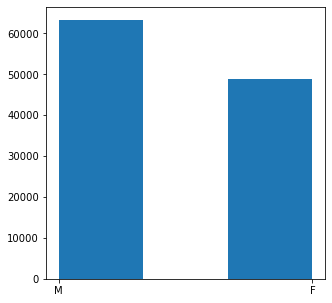

Male Patients: 837
Female Patients: 593
1.41 male to female patients


In [24]:
plt.figure(figsize=(5,5))
plt.hist(df.Patient_Gender, bins = 3)
plt.show()

male_patiens = len(list(filter(None, d_pneumonia.Patient_Gender == "M")))
female_patiens = len(list(filter(None, d_pneumonia.Patient_Gender == "F")))
print("Male Patients:", male_patiens)
print("Female Patients:", female_patiens)
print(round(male_patiens / female_patiens, 2), "male to female patients")

# Age Distribution of Pneumonia Patients

Min Age: 2
Max Age: 90
Mean Age: 44.67062937062937
Median Age: 46.0



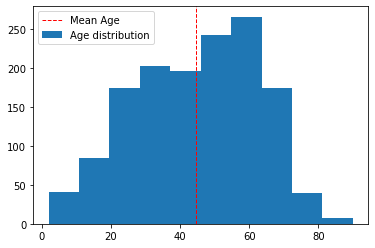

In [25]:
mean_age = np.mean(d_pneumonia.Patient_Age)
median_age = np.median(d_pneumonia.Patient_Age)
min_age = np.min(d_pneumonia.Patient_Age)
max_age = np.max(d_pneumonia.Patient_Age)

print("Min Age:", min_age)
print("Max Age:", max_age)
print("Mean Age:", mean_age)
print("Median Age:", median_age)
print("")

fig,ax = plt.subplots()

data_line = ax.hist(d_pneumonia.Patient_Age, label='Age distribution')
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=1, label='Mean Age')
legend = ax.legend(loc='upper left')

plt.show()


Patients with Pneumonia tend to be 2-3 years younger than the global population. The mean age globally was 46.85, the median was 49. People at arround 55-60 are most likely to have Pneumonia.

# Number of Diseases Per Patient

In [26]:
# Create a new df with all the patients where the Finding_Labels columns does not include "No Finding"
dpp = df[['Patient_ID', 'Finding_Labels']].copy()
is_sick = dpp['Finding_Labels'] != "No Finding"
dpp = dpp[is_sick]
dpp["number_of_diseases"] = ""

for index, row in dpp.iterrows():
    dpp.at[index,'number_of_diseases'] = len(row['Finding_Labels'].split("|"))

dpp.head()

,Patient_ID,Finding_Labels,number_of_diseases
0,1,Cardiomegaly,1
1,1,Cardiomegaly|Emphysema,2
2,1,Cardiomegaly|Effusion,2
4,3,Hernia,1
5,3,Hernia,1


In [27]:
print("There are ", dpp.shape[0], " patients with at least a single finding left.")

There are  51737  patients with at least a single finding left.


In [28]:
# Create a dict to store the dieseases and the number of diseases per patient
# Patients can occur several times in the dataset, so we need to sum the findings per patient
data = {}
unique_patients = []
for index, row in dpp.iterrows():
    patient_id = row["Patient_ID"]
    unique_patients.append(patient_id)
    if not patient_id in data:   
        data[patient_id] = []
    for e in row['Finding_Labels'].split("|"):
        data[patient_id].append(e)
    data[patient_id] =  data[patient_id]
    
for key, value in data.items():
    data[key] = {
        "diseases": set(value),
        "number_of_diseases": len(set(value))
    }

data[1]

{'diseases': {'Cardiomegaly', 'Effusion', 'Emphysema'},
 'number_of_diseases': 3}

In [29]:
print("There are", len(set(unique_patients)), "unique patients with at least one finding in the dataset")

There are 14394 unique patients with at least one finding in the dataset


In [30]:
# key = number of diseases
# value = number of patients
number_of_diseases = {}
for key, value in data.items():
    if not value["number_of_diseases"] in number_of_diseases:   
        number_of_diseases[value["number_of_diseases"]] = 0
    number_of_diseases[value["number_of_diseases"]] = number_of_diseases[value["number_of_diseases"]] + 1

number_of_diseases 

{3: 1636,
 2: 2906,
 1: 6740,
 10: 84,
 4: 1086,
 8: 204,
 5: 708,
 6: 516,
 7: 336,
 11: 28,
 9: 139,
 12: 7,
 13: 4}

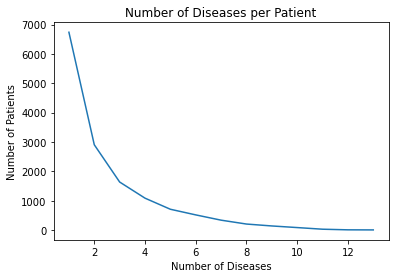

In [31]:
lists = sorted(number_of_diseases.items())
x, y = zip(*lists)
plt.plot(x, y)
plt.xlabel('Number of Diseases')
plt.ylabel('Number of Patients')
plt.title('Number of Diseases per Patient')
plt.show()

Many patients in the dataset have only one illness (6,740). With the number of findings going up, the number of patients does go down. It is interesting to see, that there are seven patiens with 12 findings and 3 patients with 13 findings.

# Medical Image Analysis

In [32]:
## helper function standardize the image
def standardize_image(imageData):
    # Find the mean and std dev intensity values of the image, and standerdize it
    mean_intensity = np.mean(imageData)
    std_intensity = np.std(imageData)
    new_img = imageData.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    return new_img

## helper function to print the image and the intensity distribution
def image_distribution(image):
    f = plt.figure()
    f.set_figwidth(10)
    
    # standardize the image data
    image = standardize_image(image)
    
    s1 = f.add_subplot(1, 2, 1)
    s1.set_title('Image')
    plt.imshow(image, cmap='gray')
    
    s2 = f.add_subplot(1, 2, 2)
    s2.set_title('Intensity Distribution')
    plt.hist(image.ravel(), bins = 256)
    
    plt.show()

In [33]:
# get the images from the patients
image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}

## Visualize Medical Images

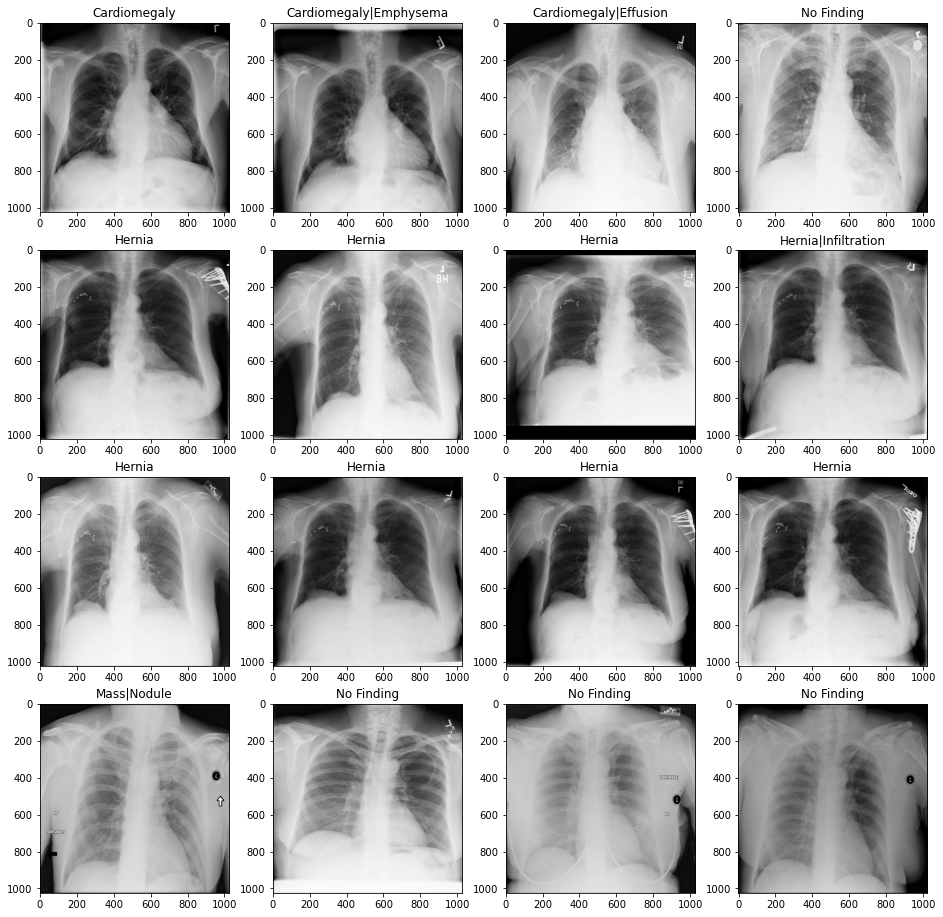

In [34]:
fig, m_axs = plt.subplots(4,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = all_xray_df['Image Index']
ind = 0

for img, ax in zip(imgs, m_axs):
    img = io.imread(image_paths[img])
    ax.imshow(img,cmap='gray')
    ax.set_title(all_xray_df.iloc[ind]['Finding Labels'])
    ind = ind + 1

# Pneumonia Samples

Image Name 00017138_066.png


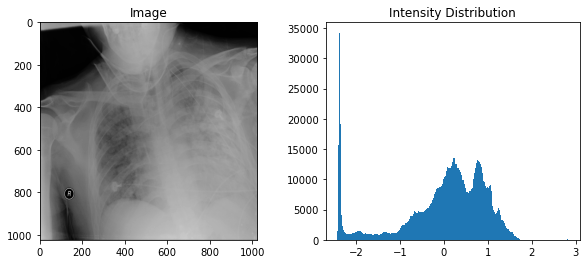

In [35]:
img = d[d['Pneumonia']==1]['Image_Index'].sample().item()
print('Image Name', img)
img = io.imread(image_paths[img])
image_distribution(img)

Image Name 00010805_047.png


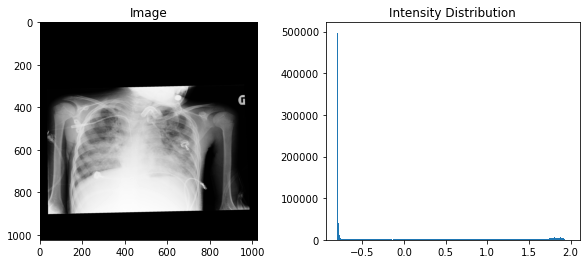

In [36]:
img = d[d['Pneumonia']==1]['Image_Index'].sample().item()
print('Image Name', img)
img = io.imread(image_paths[img])
image_distribution(img)

Image Name 00015977_002.png


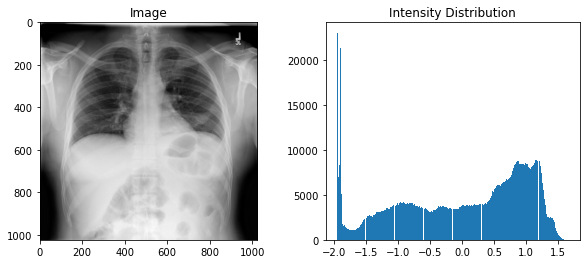

In [37]:
img = d[d['Pneumonia']==1]['Image_Index'].sample().item()
print('Image Name', img)
img = io.imread(image_paths[img])
image_distribution(img)

## Non Pneumonia Samples

Image Name 00007846_000.png


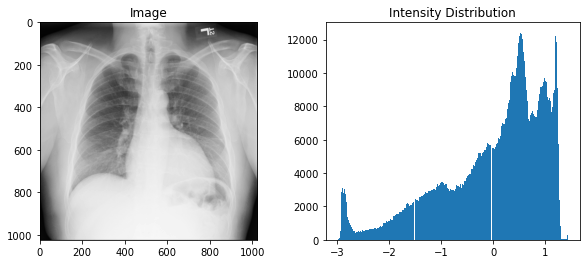

In [38]:
img = d[d['Pneumonia']==0]['Image_Index'].sample().item()
print('Image Name', img)
img = io.imread(image_paths[img])
image_distribution(img)

Image Name 00011605_014.png


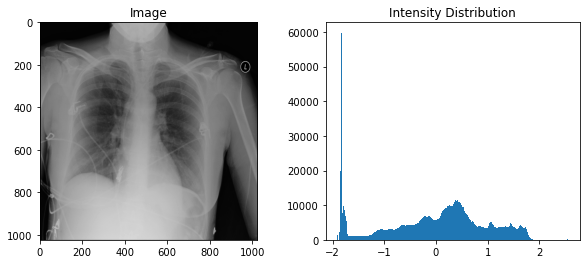

In [39]:
img = d[d['Pneumonia']==0]['Image_Index'].sample().item()
print('Image Name', img)
img = io.imread(image_paths[img])
image_distribution(img)


Image Name 00017893_006.png


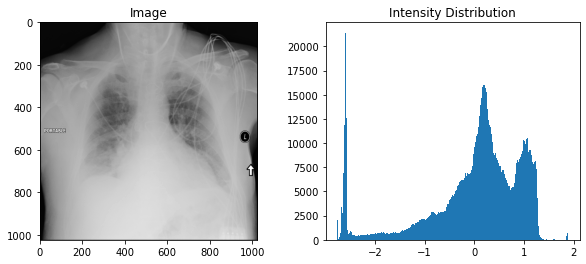

In [40]:
img = d[d['Pneumonia']==0]['Image_Index'].sample().item()
print('Image Name', img)
img = io.imread(image_paths[img])
image_distribution(img)

# Summary

In the dataset there are 112,120 chest x-rays with disease labels acquired from 30,000 patients. These x-rays originate from 63,340 male and 48,780 female patients. The ages ranges from 1 to 90, the mean age is 47, the median age is 49.

Many patients in the dataset have only one illness (6,740). With the number of findings going up, the number of patients does go down.

The most common finding in the dataset is "No Finding" with 54%. The second most finding ist "Infiltration" with 18 %. Pneumonia does occur in around 1% of all patients. Furthermore, Pneumonia occurs most often alone. The most often co-occurrence with Pneumonia is Infiltration. The third most often case is Pneumonia with Infiltration and Edema. The fourth most common co-occurrence ist Pneumonia with Atelectasis. The fourth most common case is Pneumonia with Edema. The patients with Pneumonia are not that different to the global population, the gender and age distribution are almost identical.

When analyzing the images of pneumonia vs. non-pneumonia patients, it appears that the intensity distribution of both cases follows more a normal distribution. As already stated in the README.md, the diagnosis of pneumonia from chest X-rays is difficult for several reasons:

The appearance of pneumonia in a chest X-ray can be very vague depending on the stage of the infection
Pneumonia often overlaps with other diagnoses
Pneumonia can mimic benign abnormalities
For these reasons, it is important to build a classifier which will take the demographic data of the patient and even older x-rays into account. Also it will be important that the classifier can detect Pneumonia together with other diseases, because Pneumonia does often occur together with other illnesses.